In [379]:
#!pip install opencv-python
#!pip install dlib

In [380]:
import cv2
import dlib
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리

print(cv2.__version__)
print(dlib.__version__)

4.13.0
20.0.0


#### 변수 설명
- img_bgr: OpenCV로 이미지를 불러온 Image Object. B, G, R
- img_rgb: mage Object. B, G, R --> R, G, B
- img_show: 출력용 이미지(B, G, R)
- img_show_rgb: 원본 사진 + 컴퓨터가 분석한 점(좌표) 이 모두 합쳐진 상태를 모니터로 보기 좋게 변환한 디버깅용 캔버스
- dlib_rect: 얼굴 decttion 영역

In [ ]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'Projects/AIFFEL_quest_eng/Computer_Vision/CV01/camera_sticker/images/image.png') # 본인 이미지가 있는 경로를 가지고 온다.
model_path = os.path.join(home_dir, 'Projects/AIFFEL_quest_eng/Computer_Vision/CV01/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
jeny_image =  

img_bgr = cv2.imread(my_image_path) 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_bgr.copy()  


### 아래 코드 동작설명

- 얼굴 영역(l, t, r, b)에다가 보기 좋게 매끄러운(AA) 두께 2짜리 초록색 사각형 박스를 만듬
- 얼굴의 landmark를 가져와서, 화면상에 표시해줌.
- 얼굴 ojbect가 한개 이므로 그냥 object dector에서 첫번째 배열을 가져왔습니다.

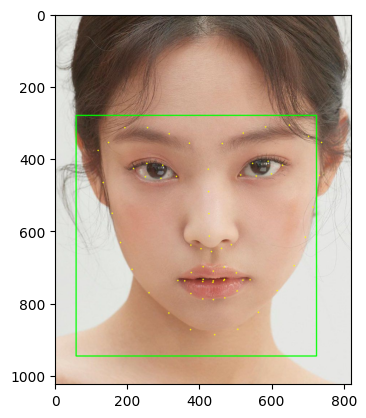

In [382]:

dlib_rect = dlib.get_frontal_face_detector()(img_rgb, 1)[0]   # (image, num of image pyramid)


l = dlib_rect.left() # 왼쪽
t = dlib_rect.top() # 위쪽
r = dlib_rect.right() # 오른쪽
b = dlib_rect.bottom() # 아래쪽

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) 

list_points = list(map(lambda p: (p.x, p.y), dlib.shape_predictor(model_path)(img_rgb, dlib_rect).parts()))
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장

for point in list_points:
    cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력


### 위치계산
- 코 바로 아래 인중으로 하는게 더 자연스러운거 같아서 인중으로 했다..
- y 좌표계산이 처음에 단순하게 list_points[33][1]를 입력했는데, 그러니까 이미지가 턱에 붙었다..
- 이미지 크기가 dlib_rect과 동일하다는것을 간과했음..

In [383]:
x = list_points[33][0]
y = list_points[33][1] - dlib_rect.height()//2
w = h = dlib_rect.width()
print (f'(x,y) : ({x},{y})')
print (f'(w,h) : ({w},{h})')

img_sticker = cv2.resize(
    cv2.imread(os.path.join(home_dir, 'Projects/AIFFEL_quest_eng/Computer_Vision/CV01/camera_sticker/images/cat-whiskers.png')), 
    (w,h)
) 

refined_x = x - w // 2 
refined_y = y 

print (f'(x,y) : ({refined_x},{refined_y})') 
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] 
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})') 

(x,y) : (433,324)
(w,h) : (667,667)
(x,y) : (100,324)
(x,y) : (100,324)


###  cat-whiskers.png 파일의 배경색 투병도 처리..
- 처음에 힌샘만 출력...배경이 255(흰색)입니다. 기존 코드는 0만 찾고 있는데 이미지는 255니까, 배경을 투명하게 만들지 못하고 하얀 박스가 그대로 나왔습니다.
- print(img_sticker[0, 0])를 찍어서 배경색이 255,255,255 인것을 확인
- 그래서 0 대신에 255로 바꾸어서  sticker_area로 잘라낸부분으로 채워습니다.

[255 255 255]


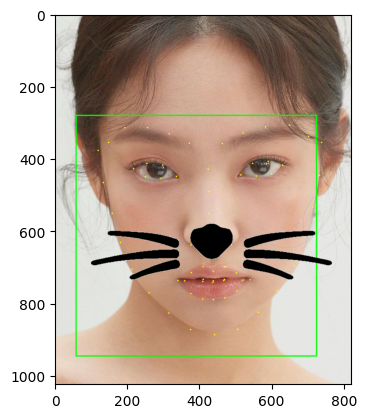

In [384]:
print(img_sticker[0, 0])

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

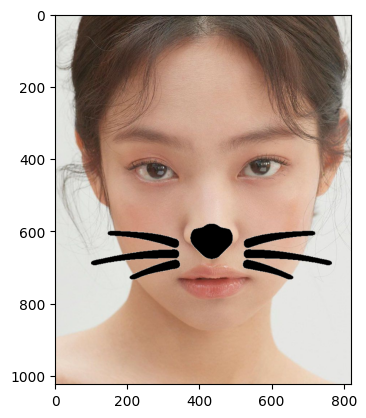

In [385]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()